# Person - anomaly detection in hourly Object Counts

This Notebook serves a purpose to identify anomalies based on the following methodology: Unusually high count of objects in a given hour.

This anomaly detection can be run in real time for invidual objects while objects are detected from the video stream. We compare a number of the already registered in the current hour against the upper threshold, which we will determine below. If the threshold breached, then we can register an anomaly.

This challenge forms a univariate outlier detection problem, which can be solved using tried and tested statistical methods.

The 2 most commonly used methods are:
- Inter Quartile Range (IQR)
- Z-Score

### IQR

IQR uses 0.25th (Q1) and 0.75th (Q3) percentiles in the dataset to determine the lower and upper bounds. Values below or above this bound are considered as outliers. Below are the equations for both bounds:

$$IQR=Q3-Q1$$
$$lowerBound=Q1-(IQR*1.5)$$
$$upperBound=Q3+(IQR*1.5)$$

The IQR multiplier 1.5 has been studied previously to produce the best results.

IQR is a very popular method to study outliers in the datasets. It is internally used in boxplots to visualize the results.

### Z-Score

Z-Score uses mean $\mu$ and standard deviation $\sigma$ to determine how far the points are distanced from the mean. Z-Score is calculated for each data point and the equation is referenced below:

$$zScore_i=(x_i-\mu)\div\sigma$$

Once we have the scores, they are compared against a threshold (it's been proven that threshold=3 tends to produce the best results) and if the score is greater, then a particular point is classified as an outlier.

### Results in practice
Both methods achieve similar results in two different ways and below is a study of their impact on the Hourly Counts in our datasets.

In [2]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

TF -> Using GPU ->  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Load, process and clean up the dataset

Here I am loading the unique hourly observation counts. Taking a look at the first few records, we can see the data shape and format below:

In [3]:
df = pd.read_csv('../Datasets/UniqueObjectDetections__person__2019-09-09_2020-03-02.csv')
print(df.shape)
df.head(2)

(4790, 26)


,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min,dummy_var,time_diff,sec_diff,x_center,y_center,prev_x_center,prev_y_center,euc_distance
0,73740,person,0.450496,459,24,478,38,2019-09-09,07.03.03,07.03.03.965_4d9909b4_person-car-car-car.jpg,2,965,2019-09-09 07:03:03.965,Monday,False,9,7,3,1,0 days 00:42:40.471000000,2560.471,468.5,31.0,490.0,310.0,279.827179
1,73135,person,0.658724,286,238,381,340,2019-09-09,07.29.50,07.29.50.440_4e0ee29d_person-car-car.jpg,1,440,2019-09-09 07:29:50.440,Monday,False,9,7,29,1,0 days 00:26:46.475000000,1606.475,333.5,289.0,468.5,31.0,291.185508


Next usual step is to make sure that the DateTime fields are converted using Pandas `to_datetime` function, so Pandas can support the next operations.

In [4]:
# make sure Pandas understands date time fields
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = pd.to_datetime(df['date'])

Now we can resample the data by hour.

This is required as currently the dataset has gaps in ours without any observations, but we want to fill these gaps with zeros, so the dataset is continous and consistent (each day should represent 24 records).

In [18]:
# use Pandas handy resample feature to fill in gaps with 0's
resampled_clean = df.set_index('date_time').resample('H')['dummy_var'].sum().reset_index()
resampled_clean.columns = ['date_time', 'obs_count']
resampled_clean['date'] = resampled_clean['date_time'].dt.date.astype(str)
resampled_clean['hour'] = resampled_clean['date_time'].dt.hour
resampled_clean = resampled_clean[['date', 'hour', 'obs_count']]

Now we need to remove all observations for the downtime days (this occurred during power outages and when disk ran out of space)

In [19]:
# remove any entries where we know that there was an error in measurements
orig_size = resampled_clean.shape[0]
idx = resampled_clean['date'].isin(['2020-01-13', '2020-01-14', '2020-02-28'])
resampled_clean = resampled_clean.loc[~idx]
print(f'Removed {orig_size - resampled_clean.shape[0]} records')

Removed 72 records


Here are a few samples from the prepared dataset:

In [20]:
resampled_clean.head(2)

,date,hour,obs_count
0,2019-09-09,7,2
1,2019-09-09,8,3


### Quick data analysis

Before we dive into the outlier detection methods, we can take a look at the dataset.

We are analysing the `obs_count` feature, which is a target value, counting historically objects detected in a given date and hour.

To see a distribution of counts, we can plot a histogram. Instead of actual counts, we can use the probability density, which tells us the probability of obtaining the distinct counts.

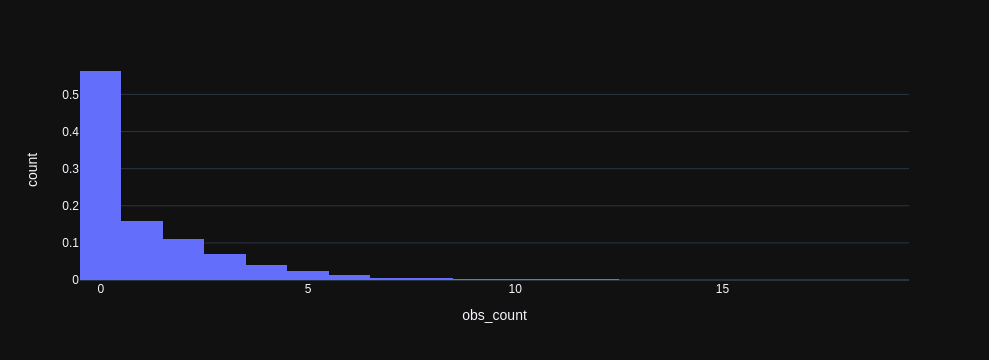

In [8]:
px.histogram(resampled_clean, x="obs_count", height=300, nbins=20, histnorm='probability density')

This data is heavily skewed towards 0's, but this is expected as during the night or when it's dark, the number of objects will be zero and we are not using a night vision camera, and in some time periods there is just not much activity going on.

But what is more interesting from and outlier detection point of view, is the long tail on the right hand side, which starts from 6 observations (only 1% chance for obtaining it!) and ends with only a single data point with 19 objects counted.

It is very clear from looking at this plot that understanding the actual thresholds at which observations are anomalous is key to the success here.

Next, we can break down the dataset by hour and calculate $\mu$ and $\sigma$ statistics for each hour.

Then we can plot them to get a better sense of the average and spread of the data points in the dataset.

In [94]:
# group by hour and generate stats at that level
grouped = resampled_clean.groupby('hour')['obs_count']
stats = grouped.agg(['mean', 'std']).reset_index()

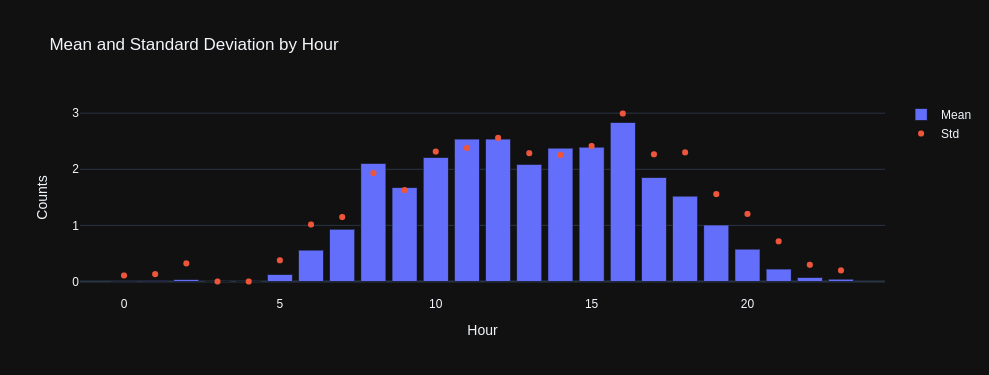

In [95]:
# construct the multi scatter plot
fig = go.Figure()
fig.add_trace(go.Bar(x=stats['hour'], y=stats['mean'], name='Mean'))
fig.add_trace(go.Scatter(x=stats['hour'], y=stats['std'], name='Std', mode='markers'))
fig.update_layout(title='Mean and Standard Deviation by Hour', height=375, xaxis_title="Hour", yaxis_title="Counts")
fig.show()

As we can see, the means follow a Normal distribution with a quite large spread between the values for each hour.

## IQR

Section below covers the IQR method.

Since botplots use IQR method to visualize outliers, we can begin by plotting a box plot for each day of the week

In [21]:
# create a copy of the dataframe not to polute the original one
resampled = resampled_clean.copy()

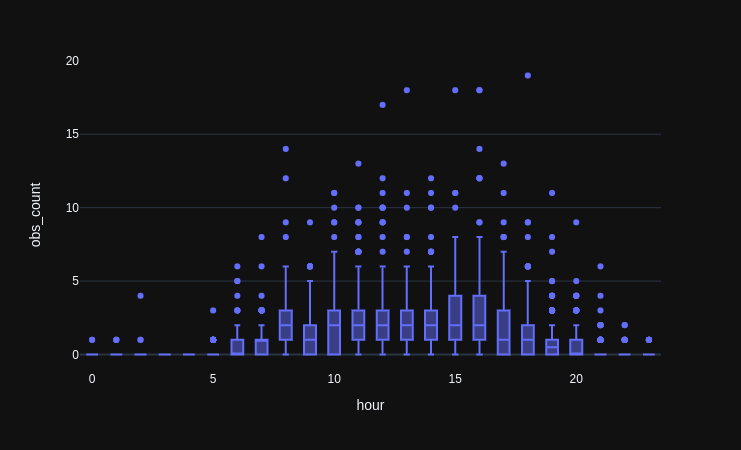

In [72]:
# create a box plot of counts for each hour
px.box(resampled, x="hour", y="obs_count", height=300)

As we can see, there are many observations classified as outliers (these can be seen by looking at the points above the upper whiskers).

Boxplots are a great tool to learn more about the analysed features. They show the median value along with the first and third percentiles.

Below I will show how this information can be used to analytically identify the outliers in a more flexible way.

### Find outlier parameters

Now that the dataset is processed and cleaned up, we can start searching for the upper and lower bounds, which is the cornerstone of the IQR method.

Below is the code snippet to calculate the IQR with lower and upper bounds for each hour individually. The base for the function below can be found in the online [Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm)

In [45]:
def find_outlier_params(df_in, col_name, iqr_multiplier=1.5):
    """Calculate outliers based on the interquartile range (IQR)"""
    q1, q3 = df_in[col_name].quantile(0.25), df_in[col_name].quantile(0.75)  # first and third quartiles
    iqr = q3 - q1  # interquartile range
    fence_low, fence_high = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr  # lower and upper bounds
    return iqr, fence_low, fence_high

In [46]:
# initialise values to fill for each hour
resampled['iqr'] = 0
resampled['fence_high'] = 0

In [47]:
# find upper fence for each hour (we don't need the lower fence any more)
for name, group in grouped:
    g = pd.DataFrame(group)
    iqr, fence_low, fence_high = find_outlier_params(g, 'obs_count', iqr_multiplier=1.5)
    idx = resampled['hour'] == name
    resampled.loc[idx, 'iqr'] = iqr
    resampled.loc[idx, 'fence_high'] = fence_high

Now, we only need to add the higher fence to the dataset, as we are not interested in the values, which are too low.

If we take a quick peek at the dataset, we can see 2 additional columns: `iqr` and `fence_high`:

In [48]:
resampled.head(2)

,date,hour,obs_count,iqr,fence_high
0,2019-09-09,7,2,1.0,2.5
1,2019-09-09,8,3,2.0,6.0


### Detect anomalies

In order to identify the anomalies, I have used the following procedure:
- initialise a new feature called `is_anomaly='N'`
- use `fence_high` determined in the previous step to indicate of a data point is an outlier:
    - actually to cater for all the 0 values during the night, I have added 1 to the `fence_high` column. It actually made the approach a little more realistic, as more strict (too low) values will trigger False Positives
- create a new parameter called `ANOMALY_THRESHOLD`, which will serve as a multiplier of `fence_high` to make outlier detection more or less aggresive. The calculation to determine is a data point is anomalous is simple and we can see it below:

$$
X(isAnomaly)=
\begin{cases}
if \; obsCount >= (fenceHigh+1)*anomalyThresh: Yes\\
else: No
\end{cases}
$$

- use this formula to update relevant records to `is_anomaly='Y'` 
- create a new column called `fence_high_adj` above which values will be treated as anomalies
- print some useful information (how many outliers were identified etc.)

In [67]:
# initialise is_anomaly to N by default
resampled['is_anomaly'] = 'N'

# this parameter adds flexibility to the anomaly detection,
# making it lower makes it more string, and making it higher
# will make it more relaxed (which will prevent False Positives)
# recommended value -> 1.5, very strict = 0.5
ANOMALY_THRESHOLD = 1.5

# identify outliers using the calculation mentioned above
idx = resampled['obs_count'] >= (resampled['fence_high'] + 1) * ANOMALY_THRESHOLD  # +1 will cater for 0-values
n_outliers = resampled[idx].shape[0]
resampled.loc[idx, 'is_anomaly'] = 'Y'
resampled['fence_high_adj'] = (resampled['fence_high'] + 1) * ANOMALY_THRESHOLD
print(f'{n_outliers} outliers detected')
print('% of outliers: ', round(n_outliers / resampled.shape[0], 2) * 100, '%')

37 outliers detected
% of outliers:  1.0 %


Now in order to highlight the magnitude of the outlier, we can create a new feature called `outlier_diff` by utilising a simple division:

$$outlierDiff=obsCount \div fenceHighAdj$$

If we take a look at a sample outlier, we can see that for the `obs_count=7` and `fence_high_adj=5.25`, the `outlier_diff=1.333`, which means that the count is 133% vs the upper fence.

In [68]:
# TODO (maybe): change this to calculate how far from the higher fence are we?
# now calculate percentage difference between the high fence and object count
resampled['outlier_diff'] = resampled['obs_count'] / resampled['fence_high_adj']
resampled[resampled['is_anomaly'] == 'Y'].head(1)

,date,hour,obs_count,iqr,fence_high,is_anomaly,fence_high_adj,upper_thresh,outlier_diff
36,2019-09-10,19,7,1.0,2.5,Y,5.25,5.25,1.333333


Now, if we plot all object counts for anomalous vs normal observations, we can see sense check if values captured as anomalies make sense. If they don't, we can re-adjust the `ANOMALY_THRESHOLD` hyperparameter.

Plotting will make a use of the `outlier_diff` to create bubble-plot for anomalous points, which will show their magnitude.

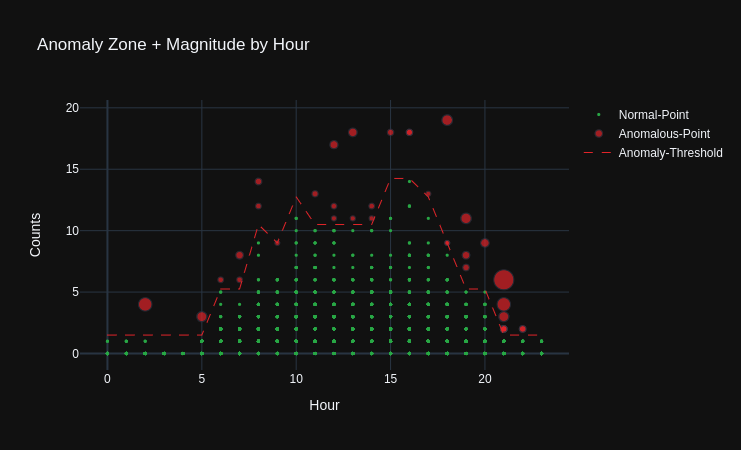

In [70]:
# select normal and anomalous slices of data
normal = resampled[resampled['is_anomaly'] == 'N']
anom = resampled[resampled['is_anomaly'] == 'Y']
# find the high fence for each hour
anom_thresh = resampled.groupby(['hour'])['fence_high_adj'].max().reset_index()

# construct the multi scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=normal['hour'], y=normal['obs_count'], name='Normal-Point', mode='markers',
                         marker=dict(color='#28a745', size=3)))
fig.add_trace(go.Scatter(x=anom['hour'], y=anom['obs_count'], name='Anomalous-Point', mode='markers',
                         marker=dict(color='#e12429', size=anom['outlier_diff'] * 5)))
fig.add_trace(go.Scatter(x=anom_thresh['hour'], y=anom_thresh['fence_high_adj'], name='Anomaly-Threshold',
                         mode='lines', line=dict(color='#e12429', width=1, dash='dash')))
fig.update_layout(title='Anomaly Zone + Magnitude by Hour', height=375, xaxis_title="Hour", yaxis_title="Counts")
fig.show()

### Study for threshold selection

The lower the `ANOMALY_THRESHOLD` multiplier is, the more outliers will be detected, and therefore more False Positives will be captured. If set too high, then legit outliers will be missed and it will result in False Negatives.

In the below plot below we observe the effect of changing this parameter within a range 0.2-1.8.

We see that setting this parameter to 0.2 will yield 33% rate for anomalous observations, and setting it to 1.8 will classify 0.6% of observations as anomalies.

Which value should be chosen here?

I believe it should be a users decision how sensitive their system should be.

I've set it to 1.5 as it seems to be capturing all anomalies acording to my preference.

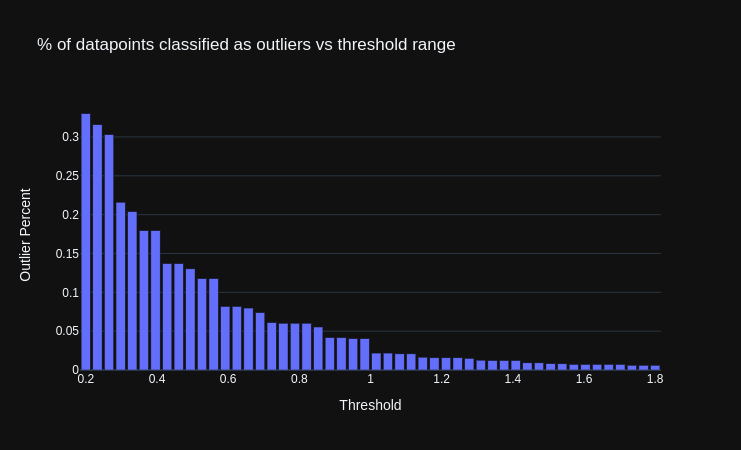

In [71]:
# create a list of thresholds within sensible range,
# then for each threshold calculate a percentage of
# data points identified as outliers
thresholds = np.linspace(0.2, 1.8, 50)
n_outliers_p = []
for t in thresholds:
    idx = resampled['obs_count'] > (resampled['fence_high'] + 1) * t
    n_outliers = resampled[idx].shape[0]
    n_outliers_p.append(n_outliers / resampled.shape[0])
    
px.bar(x=thresholds, y=n_outliers_p, height=300, labels={'x': 'Threshold', 'y': 'Outlier Percent'},
       title='% of datapoints classified as outliers vs threshold range')

## Z-Score

Section below covers the Z-Score method, which measures how many standard deviations from mean each data point is.

It is common used convention that data points below or above 3 standard deviations are considered unusual.

In the initial section of this Notebook we have created a dataframe called `resampled_clean`, which does not contain any features related to IQR. Let's use that as a starting point here.

As a reminder, here are a few sample records:

In [25]:
# create a copy of the dataframe not to polute the original one
resampled = resampled_clean.copy()

In [26]:
resampled.head(2)

,date,hour,obs_count
0,2019-09-09,7,2
1,2019-09-09,8,3


We already have the hourly statistics precalculated:

In [24]:
stats.head(2)

,hour,mean,std
0,0,0.011628,0.107517
1,1,0.017442,0.131293


Now, in order to calculate the Z-Scores for each record, we will bring in the mean and standard deviation to the dataframe with records, then the calculation will be very easy and will follow the beforementioned formula $(x-\mu) \div \sigma$

In [28]:
resampled['mean'] = resampled['hour'].map(stats.set_index('hour')['mean'])
resampled['std'] = resampled['hour'].map(stats.set_index('hour')['std'])
resampled['zscore'] = (resampled['obs_count'] - resampled['mean']) / resampled['std']

,date,hour,obs_count,mean,std,zscore
0,2019-09-09,7,2,0.930636,1.149235,0.930501
1,2019-09-09,8,3,2.104046,1.932174,0.463702


If we take a look at the distibution of scores > 0, we can see a long tail of anomalous data points.

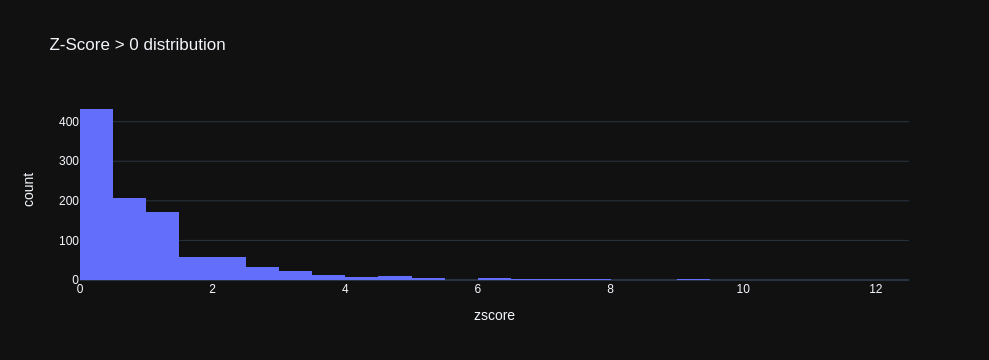

In [77]:
# now see the counts for each potential bucket
px.histogram(resampled[resampled['zscore'] > 0], x="zscore", height=300, nbins=50,
             width=600, title='Z-Score > 0 distribution')

Now we can see an example, where Z-Score value falls above 3:

$obsCount=5$, $\mu=0.559$, $\sigma=1.016$ and so $zScore=4.37$ which is $>3$

In [75]:
ANOM_THRESHOLD = 3
idx = resampled['zscore'] > ANOM_THRESHOLD
resampled[idx].head(1)

,date,hour,obs_count,mean,std,zscore,is_anomaly,fence_high_adj
23,2019-09-10,6,5,0.55814,1.01572,4.373114,Y,8.373114


How many outliers have been found overall using this method?

In [71]:
print(f'{resampled[idx].shape[0]} anomalies found with zscore > {ANOM_THRESHOLD}')

75 anomalies found with zscore > 3


An importan aspect to note here is that the number 3 is only a convention and it can help to make the anomaly detection more strict or more relaxed. 

Below we create a range from 0.5 to 6 of these numbers and plot the percentage of points it would reject.

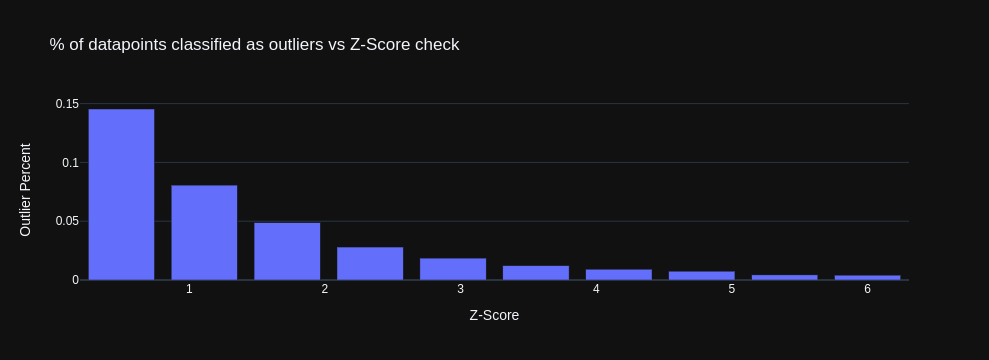

In [50]:
zscores = np.linspace(0.5, 6, 10)
n_outliers_p = []
for z in zscores:
    idx = resampled['zscore'] > z
    n_outliers = resampled[idx].shape[0]
    n_outliers_p.append(n_outliers / resampled.shape[0])

px.bar(x=zscores, y=n_outliers_p, height=300, labels={'x': 'Z-Score', 'y': 'Outlier Percent'},
       title='% of datapoints classified as outliers vs Z-Score check')

Based on the plot above let's say that we are happy with 1% of the observations classified as an outlier, then we would need to pick a value near 4.

Let's choose 4 and as before plot the outliers it would catch.

39 anomalies found with zscore > 4


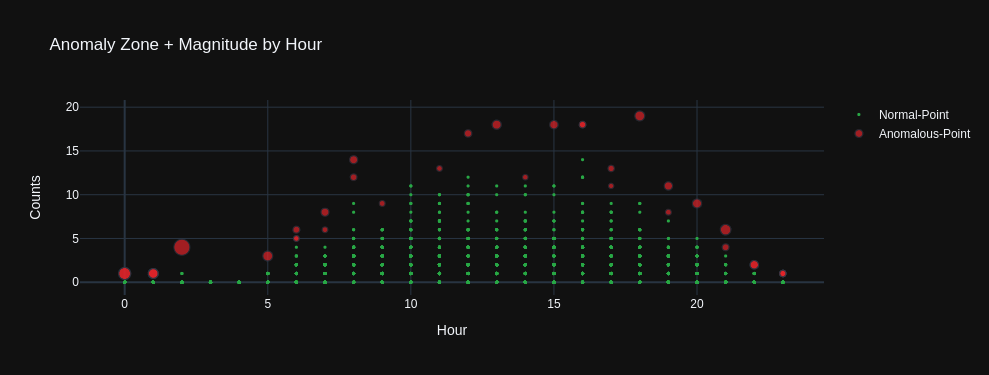

In [87]:
# define is_anomaly feature and print count of anomalous data points
ANOM_THRESHOLD = 4
resampled['is_anomaly'] = 'N'
idx = resampled['zscore'] > ANOM_THRESHOLD
resampled.loc[idx, 'is_anomaly'] = 'Y'
print(f'{resampled[idx].shape[0]} anomalies found with zscore > {ANOM_THRESHOLD}')

# select normal and anomalous slices of data
normal = resampled[resampled['is_anomaly'] == 'N']
anom = resampled[resampled['is_anomaly'] == 'Y']

# construct the multi scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=normal['hour'], y=normal['obs_count'], name='Normal-Point', mode='markers',
                         marker=dict(color='#28a745', size=3)))
fig.add_trace(go.Scatter(x=anom['hour'], y=anom['obs_count'], name='Anomalous-Point', mode='markers',
                         marker=dict(color='#e12429', size=anom['zscore'] * 1.3)))

fig.update_layout(title='Anomaly Zone + Magnitude by Hour', height=375, xaxis_title="Hour", yaxis_title="Counts")
fig.show()

### Conclusion

Both approaches have worked very well to identify the outliers.

I think that calculating a Z-Score requires slightly less computation, we don't need to deal with the 0-value observations, and it seems like tweaking the parameter seems to be a little easier too, so I would choose this method going forward to identify the hourly anomalous counts.

The parameter `ANOM_THRESHOLD` should be left to the user to configure with a sensible `default=4` and 2 other settings: `strict=3` and `relaxed=5`.